# NNX and NumPyro Integration

In this example notebook we illustrate how to incorporate neural network components from the [`NNX`](https://flax.readthedocs.io/en/v0.8.3/experimental/nnx/index.html) library into NumPyro models. In a similar way, you can use the [`Flax` Linen API](https://flax-linen.readthedocs.io/en/latest/).

This notebook is based on the blog post [Flax and NumPyro Toy Example](https://juanitorduz.github.io/flax_numpyro/).

## Prepare Notebook

In [1]:
#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz flax matplotlib

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from flax import nnx
from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.module import nnx_module
import numpyro.distributions as dist
from numpyro.handlers import condition
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

We generate a synthetic dataset with non-linear mean and standard deviation.

In [3]:
n = 32 * 10
rng_key, rng_subkey = random.split(rng_key)
x = jnp.linspace(1, jnp.pi, n)
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

Let's visualize the resulting data set:

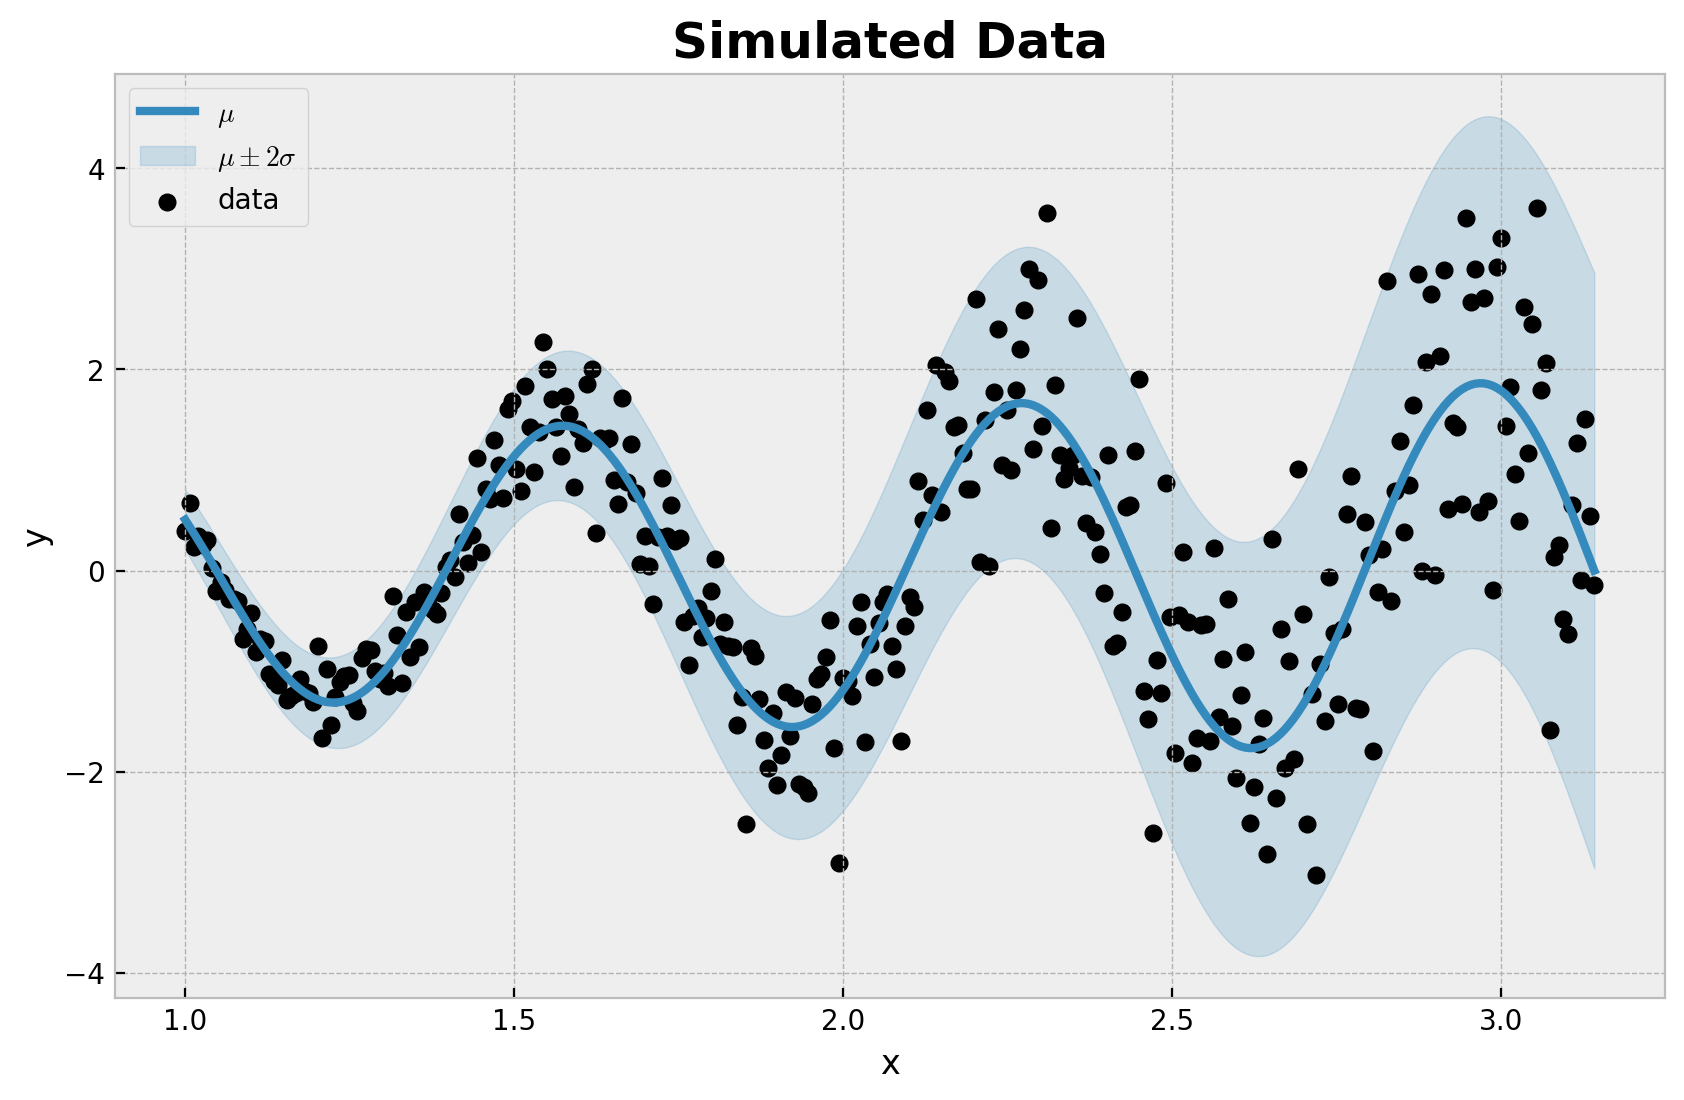

In [4]:
fig, ax = plt.subplots()
ax.plot(x, mu_true, color="C0", label=r"$\mu$", linewidth=3)
ax.fill_between(
    x,
    (mu_true - 2 * sigma_true),
    (mu_true + 2 * sigma_true),
    color="C0",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
ax.scatter(x, y, color="black", label="data")
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y");

We clearly see that the data is non-linear and has heteroskedastic noise. We would like to model the mean and standard deviation of the data as a function of the input $x$ using neural networks to model the non-linearities.

## Model Specification

First, we prepare the data for training.

In [5]:
x_train = x[..., None]
y_train = y

Next, we use `NNX` to define a $3$ layer MLP component. You can look into the [`NNX` basics](https://flax.readthedocs.io/en/v0.8.3/experimental/nnx/nnx_basics.html) for more details.

In [6]:
class MLP(nnx.Module):
    def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
        self.linear2 = nnx.Linear(dmid, dmid, rngs=rngs)
        self.linear3 = nnx.Linear(dmid, dout, rngs=rngs)

    def __call__(self, x, rngs=None):
        x = self.linear1(x)
        x = nnx.sigmoid(x)
        x = self.linear2(x)
        x = nnx.sigmoid(x)
        x = self.linear3(x)
        return x

We now define the the neural networks components in an "eager" way.

In [7]:
mu_nn_module = MLP(din=1, dmid=8, dout=1, rngs=nnx.Rngs(0))

log_sigma_nn_module = MLP(din=1, dmid=2, dout=1, rngs=nnx.Rngs(1))

Finally, we  can add the neural networks components to the NumPyro model where we use a Normal distribution for the likelihood and allow the parameters vary over the input $x$.

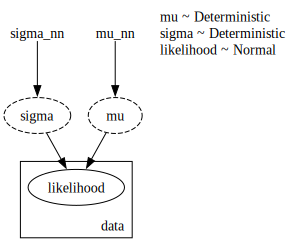

In [8]:
def model(x):
    # Neural network component for the mean
    mu_nn = nnx_module("mu_nn", mu_nn_module)
    # Neural network component for the standard deviation (in log space)
    log_sigma_nn = nnx_module("sigma_nn", log_sigma_nn_module)

    mu = numpyro.deterministic("mu", mu_nn(x).squeeze())

    sigma = numpyro.deterministic("sigma", jnp.exp(log_sigma_nn(x)).squeeze())

    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(loc=mu, scale=sigma))


numpyro.render_model(
    model=model,
    model_args=(x_train,),
    render_distributions=True,
    render_params=True,
)

## Model Inference

We now perform inference on the model using SVI.

100%|██████████| 20000/20000 [00:02<00:00, 7671.87it/s, init loss: 582.1122, avg. loss [19001-20000]: 265.3907]


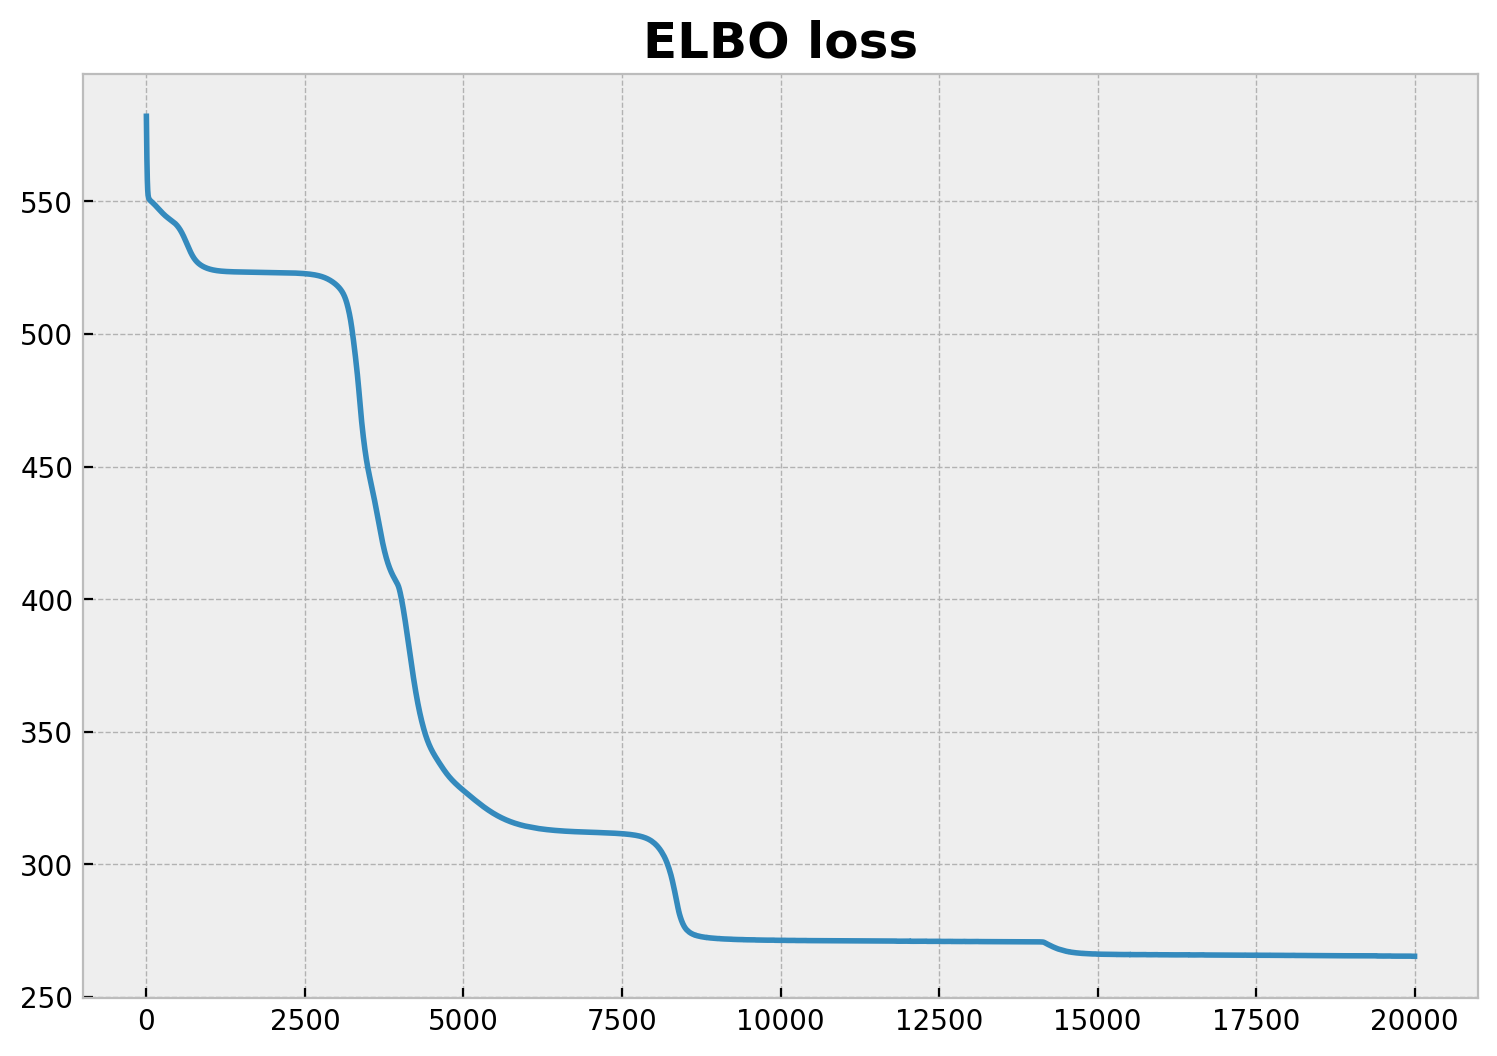

In [9]:
# We condition the model on the training data
conditioned_model = condition(model, data={"likelihood": y_train})

guide = AutoNormal(model=conditioned_model)
optimizer = numpyro.optim.Adam(step_size=0.002)
svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO(num_particles=3))
n_samples = 20_000
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(rng_subkey, n_samples, x_train)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

We now generate the posterior predictive distribution.

In [10]:
params = svi_result.params
posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=["mu", "sigma", "likelihood"],
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(rng_subkey, x_train)

Observe that we get information about the parameters of the neural networks.   

In [11]:
params["mu_nn$params"]["linear1.bias"]

Array([-12.455182 ,   6.153607 ,   9.725304 ,  17.408504 ,   9.5765705,
        -8.15588  ,  -8.75174  ,   9.871218 ], dtype=float32)

We could also get (prior) and posterior distributions by using the `random_nnx_module` instead of `nnx_module`.

We now collect the posterior predictive samples for visualization purposes.

In [12]:
obs_train = jnp.arange(x_train.size)

idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    coords={"obs": obs_train},
    dims={"mu": ["obs"], "sigma": ["obs"], "likelihood": ["obs"]},
)

Finally, we visualize the posterior predictive distribution, the mean and the standard deviation components.

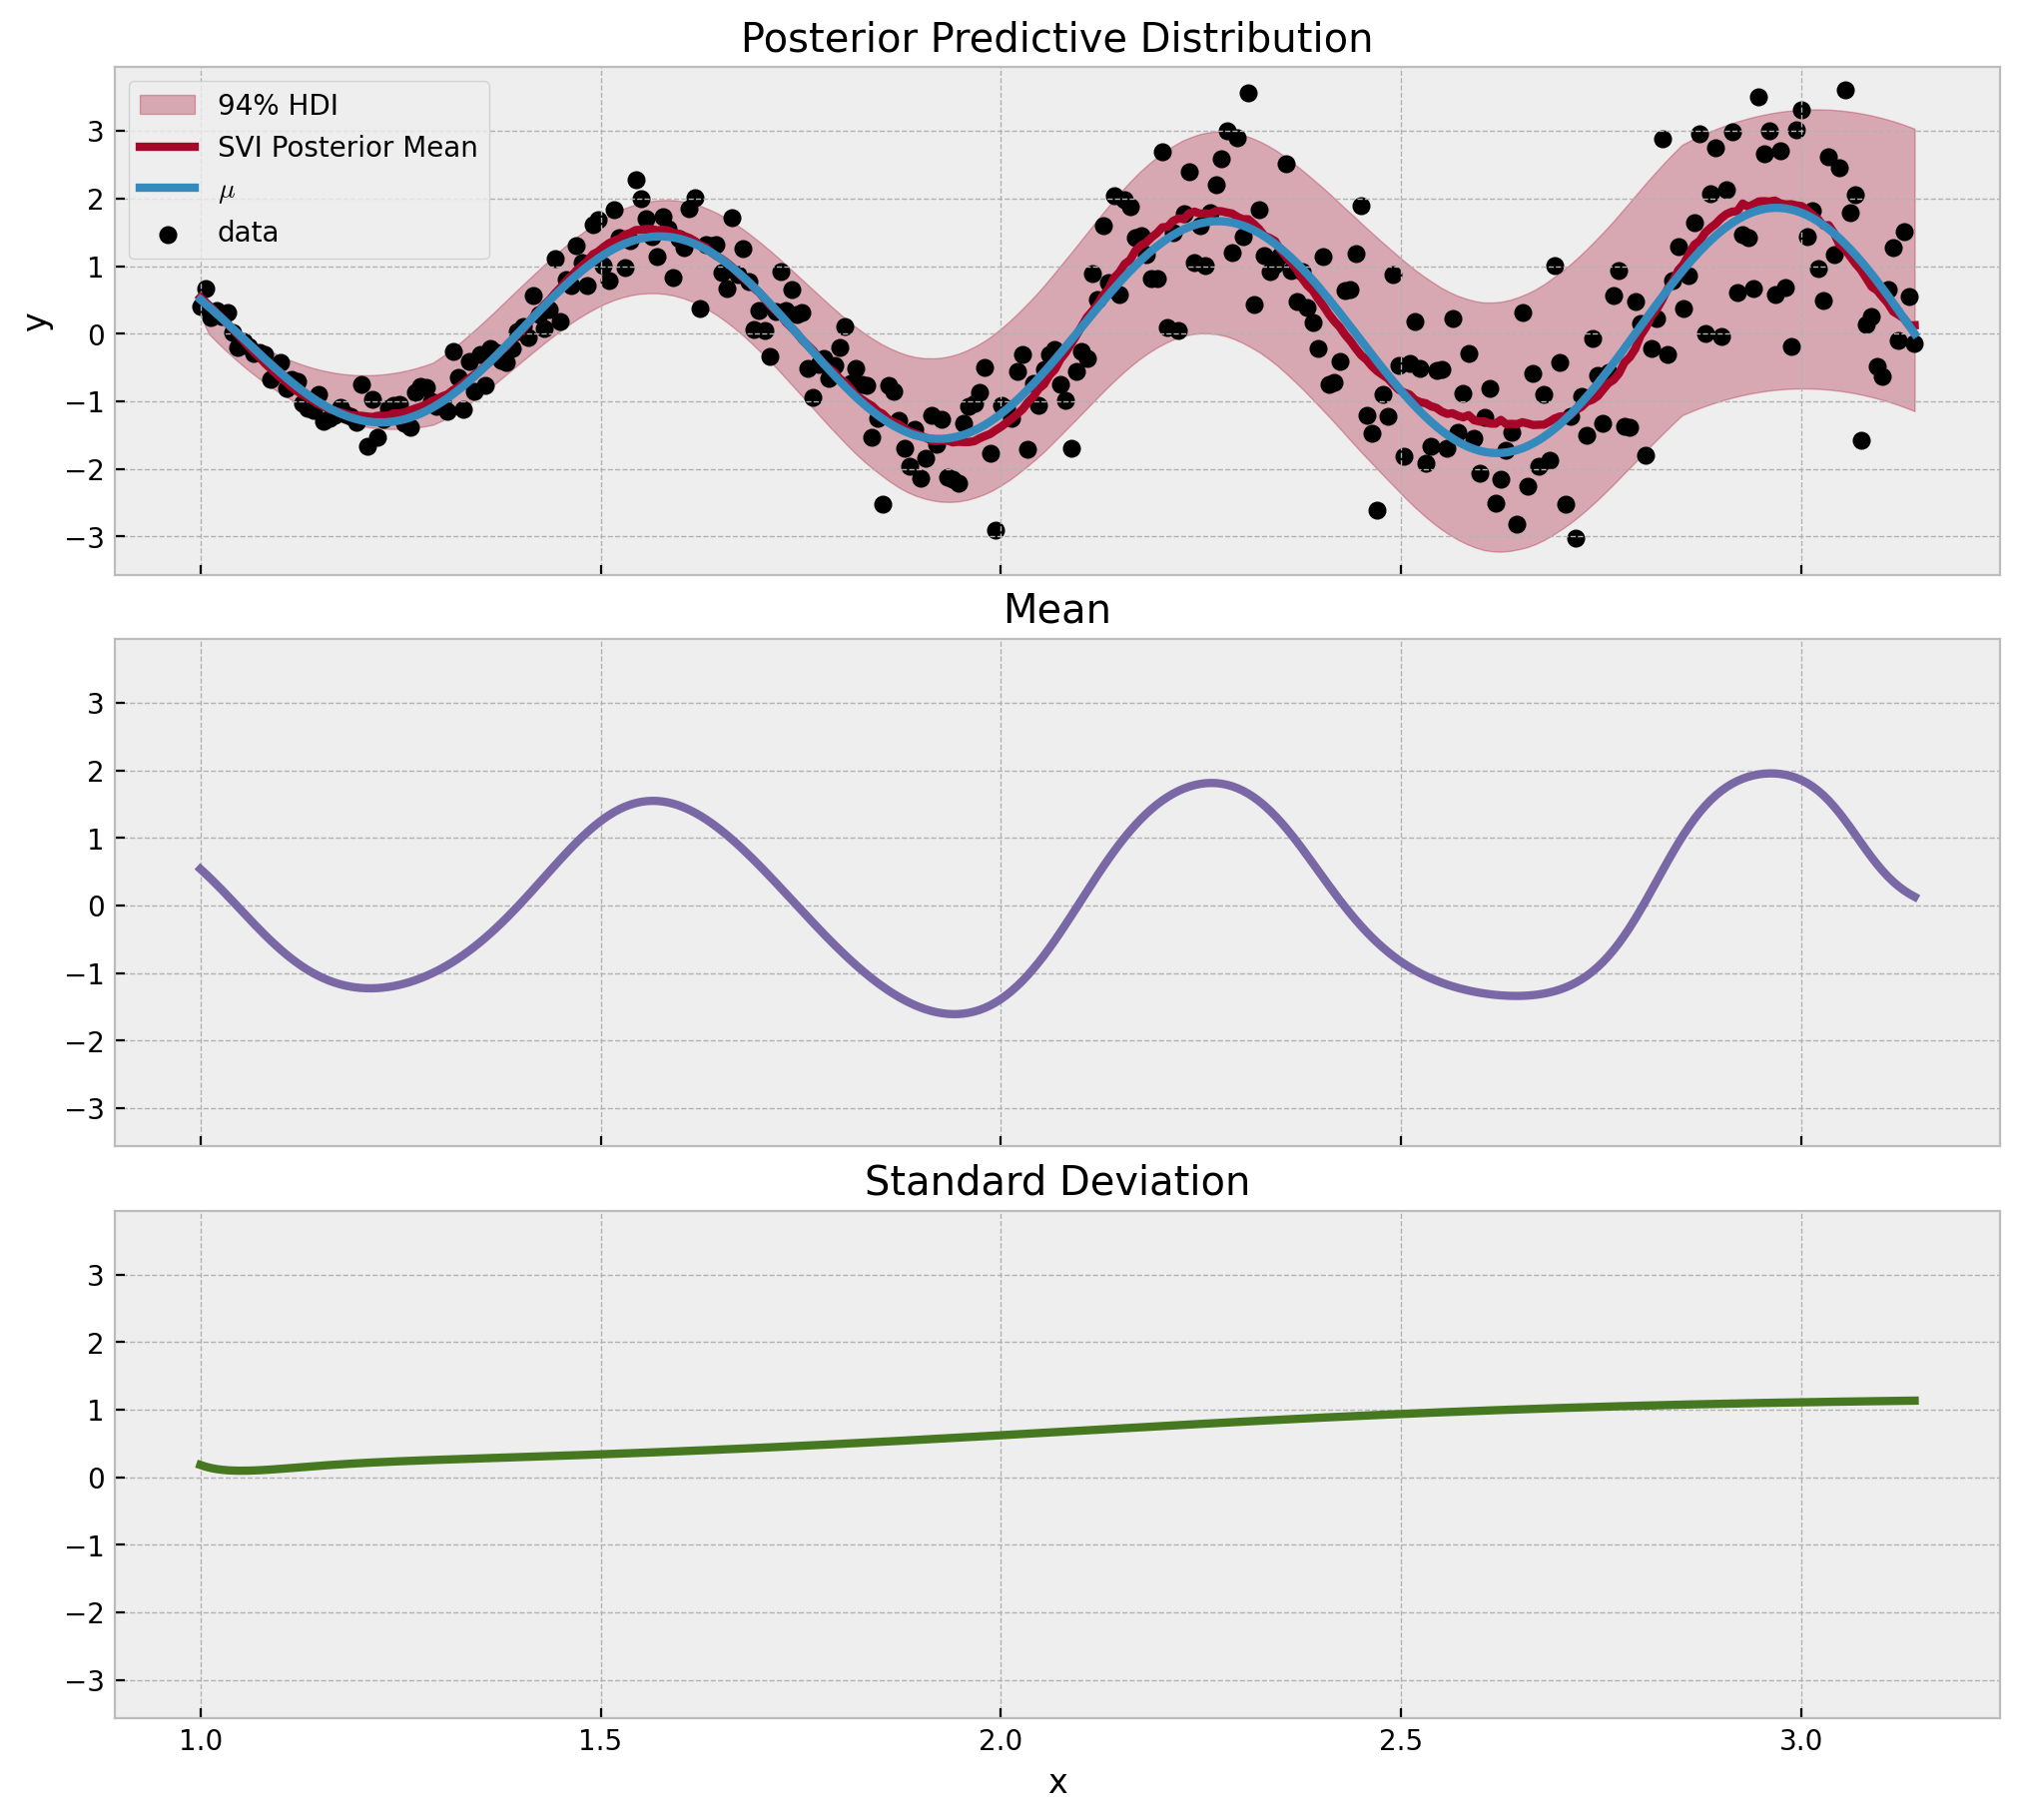

In [13]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(10, 9),
    layout="constrained",
)

az.plot_hdi(
    x,
    idata["posterior_predictive"]["likelihood"],
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
    ax=ax[0],
)
ax[0].plot(
    x_train,
    idata["posterior_predictive"]["likelihood"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="SVI Posterior Mean",
)
ax[0].plot(x, mu_true, color="C0", label=r"$\mu$", linewidth=3)
ax[0].scatter(x, y, color="black", label="data")
ax[0].legend(loc="upper left")
ax[0].set(ylabel="y")
ax[0].set_title(label="Posterior Predictive Distribution")

ax[1].plot(
    x,
    idata["posterior_predictive"]["mu"].mean(dim=("chain", "draw")),
    linewidth=3,
    color="C2",
)
ax[1].set_title(label="Mean")

ax[2].plot(
    x,
    idata["posterior_predictive"]["sigma"].mean(dim=("chain", "draw")),
    linewidth=3,
    color="C3",
)
ax[2].set(xlabel="x")
ax[2].set_title(label="Standard Deviation");

Observe that for the mean and the standard deviations we do not get posterior distributions but rather point estimates as we are using parameters for the neural networks weights and biases. As mentioned above, we can get the posterior distributions for the neural networks weights and biases by using the `random_nnx_module` instead of `nnx_module`.